In [1]:
tr_path = 'covid.train.csv'
te_path = 'covid.test.csv'

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
import os

myseed = 324960  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def show_curve(record, title = ''):
    x1 = list(range(len(record['train'])))
    x2 = x1[::len(record['train']) // len(record['dev'])]
    plt.plot(x1, record['train'], 'red', label = 'train')
    plt.plot(x2, record['dev'], 'blue', label = 'dev')
    plt.ylim(0.,20.)
    plt.xlabel('steps')
    plt.ylabel('mse')
    plt.title('mse of {}'.format(title))
    plt.legend()
    plt.show()
def show_pred(dev_set, model, device, lim = 35.0):
    model.eval()
    preds = []
    targets = []
    for x, y in dev_set:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
            targets.append(y.detach().cpu())
    preds = torch.cat(preds, dim = 0).numpy()
    targets = torch.cat(targets, dim = 0).numpy()
    # print(preds.shape)
    # print(targets.shape)
    # print(type(preds))
    figure(figsize=(5,5))
    plt.scatter(targets, preds, c = 'red', alpha=0.5)
    plt.plot([-0.2, lim],[-0.2, lim], 'blue')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth')
    plt.ylabel('preds')
    plt.title('pred')
    plt.show()

In [4]:
data = pd.read_csv(tr_path)
# data.head(10)
# data.info()
# data.describe()
# x = data[data.columns[1:94]]
# y = data[data.columns[94]]
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression

# slb = SelectKBest(f_regression, k = 15)
# x = (x - x.min()) / (x.max() - x.min())
# slb.fit(x, y)
# pd_label = pd.DataFrame(x.columns)
# pd_score = pd.DataFrame(slb.scores_)
# pd_cs = pd.concat([pd_label, pd_score], axis = 1)
# pd_cs.columns = ['l', 's']
# pd_cs.nlargest(15, 's')

In [5]:
class hw1Dataset(Dataset):
    def __init__(self, path, mode='tr'):
        super().__init__()
        data_pd = pd.read_csv(path)
        data = ( np.array(data_pd) )[:,1:].astype(float)
#         print('s={}'.format(data.shape[1]))
        feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77,92]
        if mode == 'te':
            self.data = torch.FloatTensor(data[:,feats])
        else:
            if mode == 'tr':
                data = torch.FloatTensor( [t for i , t  in enumerate(data)] )
            elif mode == 'dev':
                data = torch.FloatTensor( [t for i , t in enumerate(data)] )
#                 print(data)
#                 print('***')
#             print('l = {}'.format(len(data)))
            print(data.size(1))
            self.data = data[:,feats]
            self.target = data[:,-1]
        self.data[:,40:] = (self.data[:,40:] - self.data[:,40:].mean(dim = 0, keepdim = True)) / self.data[:,40:].std(dim = 0, keepdim = True)
        self.mode = mode
        self.dim = self.data.shape[1]
        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))
    def __getitem__(self, index):
        if self.mode == 'te':
            return self.data[index]
        else:
            return self.data[index] , self.target[index]
    def __len__(self):
        return len(self.data)

In [6]:
class hw1Net(nn.Module):
    def __init__(self , inputdim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inputdim,32),
            nn.BatchNorm1d(32),
            nn.Dropout(p = 0.1),
            nn.LeakyReLU(),
            nn.Linear(32,1)
        )
        self.criterion = nn.MSELoss(reduction ='mean')
    def forward(self,x):
        return self.net(x).squeeze(dim=1)
    def cal_loss1(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        return self.criterion(pred, target) 

    def cal_loss(self, pred, target , m):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        l2 = []
        for t in m:
            if type(t) is nn.Linear:
                l2.append((t.weight ** 2).sum() / 2.0)
        return self.criterion(pred, target) + sum(l2) * 0.1
    

In [7]:
#构造数据集函数
def create_dataLoader(path, mode , bs):
    data_set = hw1Dataset(path, mode)
    print(len(data_set))
#     print('111{}'.format(data_set[0]))
    return DataLoader(data_set, bs, shuffle = (mode == 'tr'), pin_memory=True)
    

In [8]:
config = {
    'n_epochs': 5000,
    'batch_size': 270,
    'optimizer': 'Adam',
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        # 'lr': 0.001,                 # learning rate of SGD
        # 'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 500,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [9]:
#构造数据集
tr_set = create_dataLoader(tr_path, 'tr', config['batch_size'])

dev_set = create_dataLoader(tr_path, 'dev', config['batch_size'])

te_set = create_dataLoader(te_path, 'te', config['batch_size'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(tr_set.dataset.dim)
model = hw1Net(tr_set.dataset.dim).to(device)


94
Finished reading the tr set of COVID19 Dataset (2700 samples found, each dim = 15)
2700
94
Finished reading the dev set of COVID19 Dataset (2700 samples found, each dim = 15)
2700
Finished reading the te set of COVID19 Dataset (893 samples found, each dim = 15)
893
15


In [10]:
optimizer = getattr(torch.optim,config['optimizer'])(model.parameters(), **config['optim_hparas'])


In [11]:
def dev(model, mdev_set):
    loss_sum = 0
    model.eval()
    res = 0
    for x, y in mdev_set:
        # print('???')
        # print(type(x))
        # print(type(y))
        x = x.to(device)
        y = y.to(device)
#         print('???')
        with torch.no_grad():
            pred = model(x)
#             print('p={}'.format(len(pred)))
#             print('y={}'.format(len(y)))
            loss = model.cal_loss1(pred, y)
        loss_sum += loss.detach().cpu().item() * len(x)
    
    loss_sum /= len(mdev_set.dataset)
    return loss_sum

In [12]:
def train(model, mtr_set, mdev_set):
    cnt = 0
    mmse = 1000
    res = {'train':[],'dev':[]}
    for i in range(config['n_epochs']):
        model.train()
        for x, y in mtr_set:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = model.cal_loss(pred, y, model.modules())
            loss.backward()
            optimizer.step()
            res['train'].append(loss.detach().cpu().item())
        n_loss = dev(model, mdev_set)
        res['dev'].append(n_loss)
        if mmse > n_loss:
            mmse = n_loss
            print('{}th epochs, loss is {}'.format(i + 1, mmse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            cnt = 0
        else:
            cnt += 1
        if cnt >= config['early_stop']:
            break
    return res
    
            

In [13]:
def test(model, te_set):
    preds = []
    model.eval()
    for x in te_set:
        x = x.to(device)
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.detach().cpu())
    preds = torch.cat(preds, dim = 0).numpy()
    return preds

In [14]:
c_res = train(model, tr_set, dev_set)


1th epochs, loss is 271.9164520263672
2th epochs, loss is 263.40051956176757
3th epochs, loss is 249.34386558532714
4th epochs, loss is 244.42329635620118
5th epochs, loss is 237.30668716430665
6th epochs, loss is 224.80667266845703
7th epochs, loss is 221.9421745300293
10th epochs, loss is 220.01174087524413
12th epochs, loss is 214.6972198486328
13th epochs, loss is 211.60129318237304
14th epochs, loss is 206.07325897216796
15th epochs, loss is 191.5809700012207
16th epochs, loss is 169.91219253540038
17th epochs, loss is 169.36341934204103
19th epochs, loss is 165.26427536010743
20th epochs, loss is 164.08585891723632
21th epochs, loss is 153.49995460510254
22th epochs, loss is 139.45467567443848
23th epochs, loss is 130.20213737487794
24th epochs, loss is 125.43985290527344
25th epochs, loss is 115.76747016906738
26th epochs, loss is 111.89748802185059
27th epochs, loss is 100.24737129211425
29th epochs, loss is 98.82266159057617
31th epochs, loss is 84.72778091430663
34th epochs, 

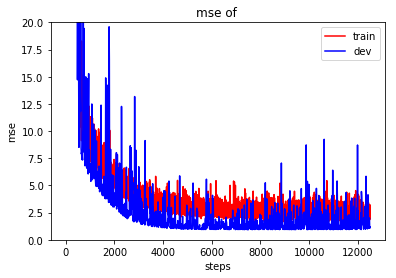

In [15]:
# print(c_res.shape)
show_curve(c_res)


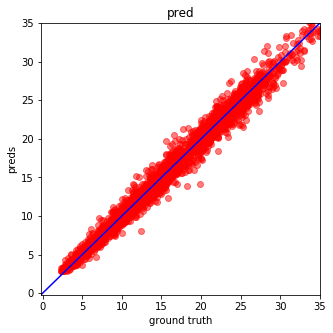

In [16]:
del model
model = hw1Net(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
show_pred(dev_set, model, device)

In [17]:
res = test(model, te_set)
df = pd.DataFrame(res, columns = ['tested_positive'])
df.to_csv('pred1.csv', index_label = 'id')